# Finetuning ViViT for Memorability prediction using the transformers library

In [1]:
!pip install av transformers

In [2]:
!pip install accelerate -U

In [3]:
import av
import numpy as np
import torch
from transformers import VivitImageProcessor, VivitForVideoClassification, VivitConfig
import pandas as pd

In [3]:
config = VivitConfig()
config

VivitConfig {
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu_fast",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-06,
  "model_type": "vivit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_frames": 32,
  "num_hidden_layers": 12,
  "qkv_bias": true,
  "transformers_version": "4.34.0",
  "tubelet_size": [
    2,
    16,
    16
  ]
}

In [45]:
def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])

def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

In [47]:
file_path = '/content/train/bathing_1-4-0-2-6-0-2-2-3214026022.mp4'
container = av.open(file_path)
container

<av.InputContainer '/content/train/bathing_1-4-0-2-6-0-2-2-3214026022.mp4'>

In [48]:
indices = sample_frame_indices(clip_len=32, frame_sample_rate=1, seg_len=container.streams.video[0].frames)
video = read_video_pyav(container=container, indices=indices)

In [49]:
image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics400")
model = VivitForVideoClassification.from_pretrained("google/vivit-b-16x2-kinetics400").to('cuda')

In [50]:
inputs = image_processor(list(video), return_tensors="pt").to('cuda')
type(inputs)

transformers.image_processing_utils.BatchFeature

In [51]:
inputs

{'pixel_values': tensor([[[[[-1.9020, -1.8706, -1.8235,  ..., -1.4784, -1.4471, -1.4471],
           [-1.9020, -1.8706, -1.8235,  ..., -1.4784, -1.4471, -1.4471],
           [-1.9020, -1.8706, -1.8235,  ..., -1.4941, -1.4471, -1.4471],
           ...,
           [-2.3412, -2.3412, -2.3412,  ..., -0.8980, -0.8980, -0.9137],
           [-2.3412, -2.3412, -2.3412,  ..., -0.8980, -0.8980, -0.9137],
           [-2.3412, -2.3412, -2.3412,  ..., -0.8980, -0.9137, -0.9137]],

          [[-2.7020, -2.6706, -2.6549,  ..., -2.3725, -2.3725, -2.3882],
           [-2.7020, -2.6706, -2.6549,  ..., -2.3725, -2.3725, -2.3882],
           [-2.7020, -2.6706, -2.6549,  ..., -2.3882, -2.3882, -2.3882],
           ...,
           [-2.5294, -2.5294, -2.5294,  ..., -1.6980, -1.7294, -1.7451],
           [-2.5294, -2.5294, -2.5294,  ..., -1.6980, -1.7294, -1.7451],
           [-2.5294, -2.5294, -2.5294,  ..., -1.6980, -1.7294, -1.7451]],

          [[-3.0000, -3.0000, -3.0000,  ..., -3.0000, -3.0000, -3.0000]

In [ ]:
inputs.pixel_values.shape

torch.Size([1, 32, 3, 224, 224])

In [ ]:
image_processor

VivitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "VivitImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "offset": true,
  "resample": 2,
  "rescale_factor": 0.00784313725490196,
  "size": {
    "shortest_edge": 224
  }
}

In [ ]:
model

VivitForVideoClassification(
  (vivit): VivitModel(
    (embeddings): VivitEmbeddings(
      (patch_embeddings): VivitTubeletEmbeddings(
        (projection): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): VivitEncoder(
      (layer): ModuleList(
        (0-11): 12 x VivitLayer(
          (attention): VivitAttention(
            (attention): VivitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): VivitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): VivitIntermediate(
           

In [ ]:
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
logits

tensor([[ 4.9269e-01, -1.8073e+00,  2.2387e+00, -9.8380e-01,  1.5020e+00,
          3.5703e-02, -5.7191e-01,  2.0959e-01,  3.2365e-01, -1.5926e+00,
          2.5823e-01,  1.6805e+00, -2.5852e-01,  2.5872e-01,  4.0161e-02,
         -6.5480e-01, -6.2771e-01, -1.6723e-01,  3.6452e-01, -5.4751e-01,
         -5.7148e-01, -2.8292e+00, -2.5252e+00,  1.2545e+00, -8.8095e-01,
         -1.7242e+00,  1.3182e+00,  2.8259e-01, -1.2742e+00, -2.6884e+00,
         -1.8614e-01, -2.5875e-01, -1.2963e-01, -2.0897e+00, -1.8719e+00,
         -2.0241e-01,  2.9157e+00,  1.6797e+00, -1.4217e+00, -2.4486e+00,
          1.3413e+00, -3.4879e+00, -2.3750e-02, -2.8458e-01,  4.8742e-01,
         -6.1452e-01, -5.3768e-01, -1.0955e+00,  9.0866e-01, -1.5741e+00,
          1.9713e+00, -2.8349e-01,  5.3863e-01, -1.8904e+00,  2.3931e+00,
         -1.2718e+00, -1.3538e+00, -1.1864e-02,  9.4274e-02, -1.5199e+00,
          1.4594e+00, -1.4285e+00, -1.3212e+00,  8.0536e-01,  1.1844e+00,
          4.3964e+00, -1.3571e+00, -1.

In [ ]:
predicted_label = logits.argmax(-1).item()
logits.argsort(descending=True)

tensor([[127,  65,  97, 289, 193, 288, 126,  36, 128, 374, 379, 133, 327, 178,
         220, 328, 152, 173, 257, 300,  54, 150, 210,   2, 347, 355, 249,  84,
         256,  70, 164,  50, 213, 187, 176, 382, 245, 184, 203, 130, 276,  81,
          98, 162, 218, 116, 261, 293, 243, 370,  77, 240, 258, 385,  11,  37,
         345, 399, 357, 396, 211,   4, 373,  80, 291, 262,  60, 165, 108, 265,
         227,  40, 175, 131,  26, 381, 266, 151, 145, 369, 109, 317,  23, 269,
          64, 163, 158, 274, 185, 241, 159, 264, 180, 233, 169, 319,  79, 235,
         301, 154, 390,  48, 188, 115, 242, 281, 338, 189, 368,  63, 148,  82,
         244, 198, 149, 208, 335, 121, 273,  86, 387, 217, 253, 386, 278, 318,
         143, 305,  96, 134, 304, 292, 140,  52, 138, 314, 222,   0,  44, 251,
         259, 394, 354,  75, 267, 248, 268,  83, 196,  18,   8, 136, 236, 297,
         326,  27,  13,  10, 377, 302, 107, 378, 389, 161,   7, 296, 283, 179,
         255, 315, 141, 202, 260, 330, 337, 168, 226

# Finetuning on corpus

In [4]:
import torch.nn as nn
import torch.nn.functional as F

import transformers
from transformers import AutoModel, AutoConfig
from transformers import VivitModel

In [7]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    CenterCrop,
    RandomHorizontalFlip,
    Resize,
)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


In [5]:
import logging
logging.basicConfig(filename="log_file_test.log",
                            filemode='a',
                            format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                            datefmt='%H:%M:%S',
                            level=logging.DEBUG,
                            force=True
                    )

In [6]:
class CustomVivit(nn.Module):
    """
    Custom Vivit model that allows finetuning
    """

    def __init__(self, model_name, num_classes, loss_fn=None, dropout_prob=0.1):
        """
        Custom Vivit model that allows finetuning

        :param model_name: The name of the model to load.
        :type model_name: str

        :param num_classes: The number of classes.
        :type num_classes: int

        :param loss_fn: The loss function to use.
        :type loss: torch.nn.modules.loss._Loss

        :param dropout_prob: The dropout probability to use.
        :type dropout_prob: float

        :return: None
        """
        super().__init__()
        self.model_name = model_name
        self.num_classes = num_classes
        self.loss_fn = loss_fn
        self.dropout_prob = dropout_prob
        self.base_model = self.get_model()
        self.dropout = nn.Dropout(dropout_prob)
        # Classifier must have a dense, dropout and linear layer
        self.classifier = nn.Sequential(
            nn.Linear(self.base_model.config.hidden_size, self.base_model.config.hidden_size),
            nn.Dropout(dropout_prob),
            nn.Linear(self.base_model.config.hidden_size, self.num_classes)
        )


    # Make it work so that calling the model() calls the forward() method
    def __call__(self, pixel_values, labels=None):
        return self.forward(pixel_values, labels)


    def get_model(self):
        """
        Get the model

        :return: The model
        """
        return AutoModel.from_pretrained(self.model_name)



    def forward(self, pixel_values, labels=None):
        """
        Forward pass

        :param pixel_values: The pixel values.
        :type pixel_values: torch.Tensor

        :param labels: The labels.
        :type labels: torch.Tensor

        :return: The loss and logits
        """
        # Get the last hidden state
        last_hidden_state = self.base_model(pixel_values).last_hidden_state
        # Get the CLS token
        cls_token = last_hidden_state[:, 0, :]
        # Apply dropout
        cls_token = self.dropout(cls_token)
        # Apply the classifier
        logits = self.classifier(cls_token)
        # If labels are provided, compute the loss
        if labels is not None and self.loss_fn is not None:
            return self.loss_fn(logits, labels), logits
        else:
            return logits

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_ft = CustomVivit("google/vivit-b-16x2-kinetics400",1).to(device)
model_ft

Some weights of VivitModel were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized: ['vivit.pooler.dense.bias', 'vivit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CustomVivit(
  (base_model): VivitModel(
    (embeddings): VivitEmbeddings(
      (patch_embeddings): VivitTubeletEmbeddings(
        (projection): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): VivitEncoder(
      (layer): ModuleList(
        (0-11): 12 x VivitLayer(
          (attention): VivitAttention(
            (attention): VivitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): VivitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): VivitIntermediate(
            (dense): L

In [8]:
image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics400")

In [73]:
image_processor

VivitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "VivitImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "offset": true,
  "resample": 2,
  "rescale_factor": 0.00784313725490196,
  "size": {
    "shortest_edge": 224
  }
}

In [9]:
import os
import random

# Function to generate a random number between 0 and 1
def generate_random_number():
    return random.uniform(0, 1)

# Function to scan a folder and create a dictionary
def create_dictionary_from_folder(folder_path):
    video_dict = {}
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.mp4', '.avi', '.mkv', '.mov')):
                video_path = os.path.join(root, file)
                random_number = generate_random_number()
                video_dict[video_path] = random_number
    return video_dict

train_path = "/content/train"
test_path = "/content/test"

# Create dictionaries for both folders
train_dict = create_dictionary_from_folder(train_path)
test_dict = create_dictionary_from_folder(test_path)


In [26]:
train_list = list(train_dict.keys())
test_list = list(test_dict.keys())

In [10]:
num_frames_to_sample = model_ft.base_model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps

In [63]:
class VideoDataset(torch.utils.data.Dataset):
    default = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics400")

    """
    Dataset class to handle video loading and preprocessing.
    Receives a dictionary in which the key is the path to the video and the value is the label.

    When the dataset is loaded, the videos are processed using an image processor (default is VivitImageProcessor).

    The result is a dictionary with the following keys:
        - pixel_values: tensor of shape (n_frames, n_channels, height, width)
        - label: tensor of shape (1)
    """

    def _read_video_pyav(self, container, indices):
        '''
        Decode the video with PyAV decoder.
        Args:
            container (`av.container.input.InputContainer`): PyAV container.
            indices (`List[int]`): List of frame indices to decode.
        Returns:
            result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
        '''
        frames = []
        container.seek(0)
        start_index = indices[0]
        end_index = indices[-1]
        for i, frame in enumerate(container.decode(video=0)):
            if i > end_index:
                break
            if i >= start_index and i in indices:
                frames.append(frame)
        return np.stack([x.to_ndarray(format="rgb24") for x in frames])

    def _sample_frame_indices(self, clip_len, frame_sample_rate, seg_len):
        '''
        Sample a given number of frame indices from the video.
        Args:
            clip_len (`int`): Total number of frames to sample.
            frame_sample_rate (`int`): Sample every n-th frame.
            seg_len (`int`): Maximum allowed index of sample's last frame.
        Returns:
            indices (`List[int]`): List of sampled frame indices
        '''
        converted_len = int(clip_len * frame_sample_rate)
        end_idx = np.random.randint(converted_len, seg_len)
        start_idx = end_idx - converted_len
        indices = np.linspace(start_idx, end_idx, num=clip_len)
        indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
        return indices

    def __init__(
            self,
            data: pd.DataFrame,
            video_col: str,
            label_col: str,
            clip_len,
            frame_sample_rate,
            processor = None
            ) -> None:
        """

        """
        self.videos = []
        self.labels = []
        self.clip_len = clip_len
        self.frame_sample_rate = frame_sample_rate
        self.processor = self.default if not processor else processor

        for _, (video_path, label) in data[[video_col, label_col]].iterrows():
            self.videos.append(video_path)
            self.labels.append(label)

    def __len__(self) -> int:
        return len(self.videos)

    def __getitem__(self, idx: int):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        container = av.open(self.videos[idx])
        indices = self._sample_frame_indices(self.clip_len, self.frame_sample_rate, container.streams.video[0].frames)
        video = self._read_video_pyav(container, indices)
        label = torch.tensor(self.labels[idx]).float()
        inputs = self.processor(list(video), return_tensors='pt')
        inputs = {k: val.squeeze() for k, val in inputs.items()}
        return inputs, label

    def load(self, phase: str = 'train', batch_size: int = 32,
                num_workers: int = 0) -> torch.utils.data.DataLoader:
            """Retrieve a DataLoader to ease the pipeline.

            Args:
                phase: Whether it's train or test.
                batch_size: Samples per batch.
                num_workers: Cores to use.

            Returns:
                an iterable torch DataLoader.
            """
            shuffle = True if phase == "train" else False
            return torch.utils.data.DataLoader(dataset=self, batch_size=batch_size,
                            shuffle=shuffle, num_workers=num_workers)

In [64]:
train_dataset = VideoDataset(
    pd.DataFrame({'filename': train_dict.keys(), 'label': train_dict.values()}),
    'filename', 'label',
    32,
    1
)

In [65]:
test_dataset = VideoDataset(
    pd.DataFrame({'filename': test_dict.keys(), 'label': test_dict.values()}),
    'filename', 'label',
    32,
    1
)

In [14]:
next(iter(train_dataset))

/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:149: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.tensor(value)


({'pixel_values': tensor([[[[[-2.8431, -2.8431, -2.8431,  ..., -2.8118, -2.8118, -2.8118],
             [-2.8431, -2.8431, -2.8431,  ..., -2.8118, -2.8118, -2.8118],
             [-2.8431, -2.8431, -2.8431,  ..., -2.8118, -2.8118, -2.8118],
             ...,
             [-0.4588, -0.4431, -0.4275,  ..., -1.1647, -1.0392, -0.8980],
             [-0.4902, -0.4588, -0.4431,  ..., -1.1490, -1.0549, -0.8980],
             [-0.5059, -0.4745, -0.4431,  ..., -1.1333, -1.0392, -0.8980]],
  
            [[-2.8745, -2.8902, -2.8902,  ..., -2.8431, -2.8431, -2.8431],
             [-2.8745, -2.8902, -2.8902,  ..., -2.8431, -2.8431, -2.8431],
             [-2.8745, -2.8902, -2.8902,  ..., -2.8431, -2.8431, -2.8431],
             ...,
             [-2.3725, -2.3569, -2.3569,  ..., -1.9961, -1.9490, -1.8863],
             [-2.3412, -2.3098, -2.3098,  ..., -1.9804, -1.9647, -1.8863],
             [-2.3255, -2.2941, -2.2941,  ..., -1.9804, -1.9490, -1.8863]],
  
            [[-2.8588, -2.8275, -2.8275,

In [15]:
next(iter(train_dataset))[0]["pixel_values"].shape

torch.Size([1, 32, 3, 224, 224])

 (repeated 31 more times)


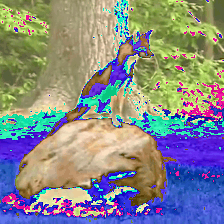

In [36]:
import imageio
import numpy as np
from IPython.display import Image

import itertools

mean = image_processor.image_mean
std = image_processor.image_std

def unnormalize_img(img, mean, std):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)
    return img

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """

    frames = []

    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).cpu().numpy(),
                                             mean, std)
        frames.append(frame_unnormalized)

    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):

    """Prepares and displays a GIF from a video tensor."""

    # video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

sample_video = next(itertools.islice(iter(train_dataset), 25, None))

video_tensor = sample_video[0]["pixel_values"]

display_gif(video_tensor)

In [37]:
outputs = model_ft(sample_video[0]["pixel_values"],sample_video[1])
outputs

tensor([[-0.2987]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [70]:
from transformers import TrainingArguments, Trainer

model_ckpt = "google/vivit-b-16x2-kinetics400"
model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-memento-subset"
num_epochs = 4
batch_size = 2

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    push_to_hub=True,
    max_steps=(len(train_dataset) // batch_size) * num_epochs,
)

In [71]:
def collate_fn(examples):

    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example[0]["pixel_values"] for example in examples]
    )
    labels = torch.tensor([example[1] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [20]:
from huggingface_hub import notebook_login

notebook_login()

In [72]:
trainer = Trainer(
    model_ft,
    args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=image_processor,
    data_collator=collate_fn
)

In [75]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

489

In [76]:
trainer.train()

OutOfMemoryError: ignored

## Playground